In [1]:
import torch
import matplotlib.pyplot as plt
from utils.defects import S_cal
import numpy as np
import pickle
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import torch.nn as nn
import tensorboard

from kinetic_solver import KineticSolver, KineticData
from stable_baselines3 import PPO
from utils.model import DownSampleConv
from utils.defects import theta_cal, S_cal
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.policies import ActorCriticCnnPolicy
from kinetic_solver import KineticSolver, KineticData
from nematic_env import ActiveNematicEnv

# 初始化物理仿真器
geo_params = {
    'N': 256,
    'Nth': 256,
    'L': 10
}
flow_params = {
    'dT': 0.3,
    'dR': 0.3,
    'alpha': -10,
    'beta': 1.0,
    'zeta': 2,
    'V0': 0.0
}
simu_params = {
    'dt': 0.0004,
    'seed': 1234,
    'inner_steps': 160,
    'outer_steps': 64
}
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'




In [2]:
solver_paras = (geo_params, flow_params, simu_params)
# env = ActiveNematicEnv(solver_paras, device=device)

# solver_paras = (geo_params, flow_params, simu_params)

solver = KineticSolver(*solver_paras, device=device)
data_path = '/home/hou63/pj2/Nematic_RL/datas/simulation_data_test.pkl'
# simulation_data = KineticData(*solver.initialize2_pytorch(seed=918), solver.simu_args)
simulation_data = KineticData.loader(data_path)
# simulation_data = solver.preloop_kinetic(simulation_data, num_itr=32000)
print(simulation_data)
simulation_data = simulation_data.loader(data_path)
env = ActiveNematicEnv(solver_paras, solver=solver,
                        simulation_data=simulation_data, device=device,
                        data_path=data_path)


 dx_  0.0390625  dth_  0.02454369260617026  dt  0.0004


Pre iteration done.


0.7789390087127686
0.778939


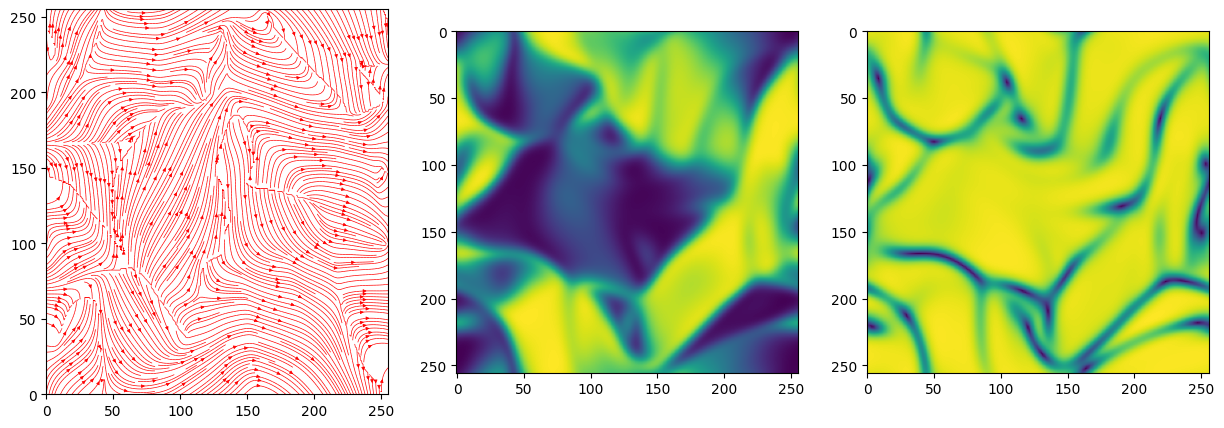

In [3]:
print(env._calculate_reward())

d11, d12 = simulation_data.get_D()
S = S_cal(d11.cpu().data.numpy(), d12.cpu().data.numpy())
print(S.mean())
d11 = d11.cpu().data.numpy()
d12 = d12.cpu().data.numpy()
theta = 0.5 * np.arctan2(2*d12, 2*d11-1)
# plot S

cost, sint = np.cos(theta), np.sin(theta)

fig, ax1 = plt.subplots(1,3, figsize=(15, 5))
ax1[0].streamplot(np.arange(0, theta.shape[0]), np.arange(0, theta.shape[1]),
                cost, sint, arrowsize=0.5, color='r',
                density=4, linewidth=0.5)

ax1[1].imshow(d11)
# set colorbar

ax1[2].imshow(S)
plt.show()

In [ ]:
check_env(env)

In [ ]:
# check_env(env)
# # 使用PPO算法进行强化学习
model = PPO(
    ActorCriticCnnPolicy, env, verbose=1, device=device,
    n_steps=4, batch_size=4,
    tensorboard_log="/home/hou63/pj2/Nematic_RL/logs")
model.learn(total_timesteps=128)

Using cuda:0 device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Logging to /home/hou63/pj2/Nematic_RL/logs/PPO_3
---------------------------
| time/              |    |
|    fps             | 0  |
|    iterations      | 1  |
|    time_elapsed    | 27 |
|    total_timesteps | 4  |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 0           |
|    iterations           | 2           |
|    time_elapsed         | 53          |
|    total_timesteps      | 8           |
| train/                  |             |
|    approx_kl            | 0.064275995 |
|    clip_fraction        | 0.35        |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.51       |
|    explained_variance   | 0.0352      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0923     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.101      |
|    std                  | 1           |
|    value_loss           | 0.952       |

In [ ]:
# save model
model.save("/home/hou63/pj2/Nematic_RL/models/ppo_nematic")
